## =Random Forest Model=

# Imports

In [1]:
import numpy as np
import math

import itertools

import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
path = 'datasets/coins project/neo_full.csv'
data = pd.read_csv(path)
data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  
0                 0                0                 19  
1                 0                0                 19  
2                 0                0                 19  
3                 0                0                 20  
4                 0                0                 20

# Preprocessing

In [3]:
zero_cleaner_features =['twitterFollowers','redditSubscribers','forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues','pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
features =['price', 'volume', 'marketCap', 'twitterFollowers',
       'redditAveragePosts48h', 'redditAverageComments48h',
       'redditSubscribers', 'redditAccountsActive48h',
        'alexaRank', 'forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues',
       'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']

def zero_cleaner(column):
    up =0
    for i in range(len(column)):
        val = column[i]
        if column[i] == 0 and up ==0 and i >=1:
            up = column[i-1]
        if column[i] != 0 and up!=0:
            j=i
            ave = (column[i]+up)/2
            while j>=1 and column[j-1] ==0:
                column[j-1] = ave
                j-=1
            up = 0
        # today fix
        if i == len(column)-1 and val==0:
            column[i] = up

def target_generator(data):
    b = data['price']
    in_days = 1
    target = 'price_in_{}_day'.format(in_days)
    data[target] = data['price']
    a = data[target]
    for i in range(len(b)):
        if i<len(b)-in_days:
            a[i] = b[i+in_days]
        else:
            a[i] = b[i-5:i].mean()
                        
def cleaner(data):
    for feature in zero_cleaner_features:
        zero_cleaner(data[feature])
    target_generator(data)

In [4]:
cleaner(data)               
data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  price_in_1_day  
0                 0                0                 19       30.957925  
1                 0                0                 19       23.023138  
2                 0                0                 19       23.674946  
3                 0                0                 20       21.515456  
4                 0                0                 20       30.842616

# Train

In [8]:
def fit_and_predict(data, **params):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    feat = ['price', 'volume', 'marketCap', 'twitterFollowers',
       'redditAveragePosts48h', 'redditAverageComments48h',
       'redditSubscribers', 'redditAccountsActive48h',
       'telegramChanelUserCount', 'alexaRank', 'bingMatches', 'forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues', 'pullRequestsMerged',
       'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
    
    # Create linear regression object
    regr = RandomForestRegressor(random_state=0,
                                     n_estimators= 200,
                                     min_samples_split= 5,
                                     min_samples_leaf= 1,
                                     max_features= 'sqrt',
                                     max_depth= 35,
                                     bootstrap= True)

    pred_list = []
    # For Tuning
    if len(params)>0:
        params = params['params']['params']
        n_estimators= params[0]
        max_features= params[1]
        max_depth= params[2]
        min_samples_split= params[3]
        min_samples_leaf= params[4]
        bootstrap= params[5]
        regr = RandomForestRegressor(random_state=0,
                                     n_estimators= n_estimators,
                                     min_samples_split= min_samples_split,
                                     min_samples_leaf= min_samples_leaf,
                                     max_features= max_features,
                                     max_depth= max_depth,
                                     bootstrap= bootstrap)
        
        
    pred_min = 0
    
#     X_train = data[data.shape[0]-N-1:data.shape[0]-1][feat]
#     y_train = data[data.shape[0]-N-1:data.shape[0]-1]['price_in_1_day']
    
    X_train = data[:data.shape[0]-1][feat]
    y_train = data[:data.shape[0]-1]['price_in_1_day']
    test = data.tail(1)[feat]
    regr.fit(X_train, y_train)
    
    pred = regr.predict(test)
    pred = pred[0]
    # If the values are < pred_min, set it to be pred_min    
    if pred < pred_min:
        pred = pred_min

    today_price = data.iloc[-1]['price']
    tomorrow_price = pred
    tomorrow_percentage = ((tomorrow_price - today_price) / abs(today_price)) * 100
    return {'today_price': today_price, 'tomorrow_price': tomorrow_price, 'tomorrow_percentage': tomorrow_percentage}
   

In [9]:
fit_and_predict(data)

{'today_price': 11.427525396480426,
 'tomorrow_price': 11.362046003859378,
 'tomorrow_percentage': -0.5729971306055068}

# Simulation & Predict

In [14]:
simulation_size = 30
data_size = data.shape[0]
print('data size:{} = train size:{} + test size:{}'.format(data_size, data_size-simulation_size, simulation_size ))
true_values = data[data_size-simulation_size:]['price'].values

def simulation(**params):
    predict_values = []
    for i in range(simulation_size,0,-1):
        today_data = data[:data_size-i]
    
        if len(params):
            tomorrow_predict = fit_and_predict(today_data, params = params)
        else:
            tomorrow_predict = fit_and_predict(today_data)
            
        predict_values.append(tomorrow_predict['tomorrow_price'])
    return predict_values

data size:1057 = train size:997 + test size:60


In [15]:
predict_values = simulation()

# Evaluation

In [16]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_rmse(y_true, y_pred): 
    return math.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

def plot_trend(true_trend,pred_trend = [], split_point=0, full_x=False, title=''):
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(true_trend,'blue',label = "true values",alpha=0.6)
    if len(pred_trend) >0:
        plt.plot(pred_trend,'red',label ='prediction',alpha=0.6)
    plt.legend(loc="upper left")
    plt.title(title)
    if full_x ==True:
        plt.xticks(range(len(true_trend)))
        plt.grid(True)
    if split_point !=0:
        plt.axvline(x=split_point,linewidth=2.5)
    plt.show()

def make_report(y_pred , y_true):
    print ("")
    print ("Classification Report: ")
    print (classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()

def classify_report(true_values,predict_values):
    t = []
    p = []
    yesterday = data[data_size-simulation_size-1:data_size-simulation_size].price.values[0]
    for i in range(len(predict_values)):
        if yesterday < true_values[i]:
            t.append(1)
        else:
            t.append(0)
        if yesterday < predict_values[i]:
            p.append(1)
        else:
            p.append(0)
        yesterday = true_values[i]
    make_report(p,t)
    
def full_result(true_values,predict_values):
    rmse = get_rmse(true_values,predict_values)
    mape = get_mape(true_values,predict_values)
    title ='result of {} days of simulation \n\nrmse: {}\nmape: {}'.format(simulation_size,rmse,mape)
    plot_trend(true_values,predict_values, title = title)
    classify_report(true_values,predict_values)

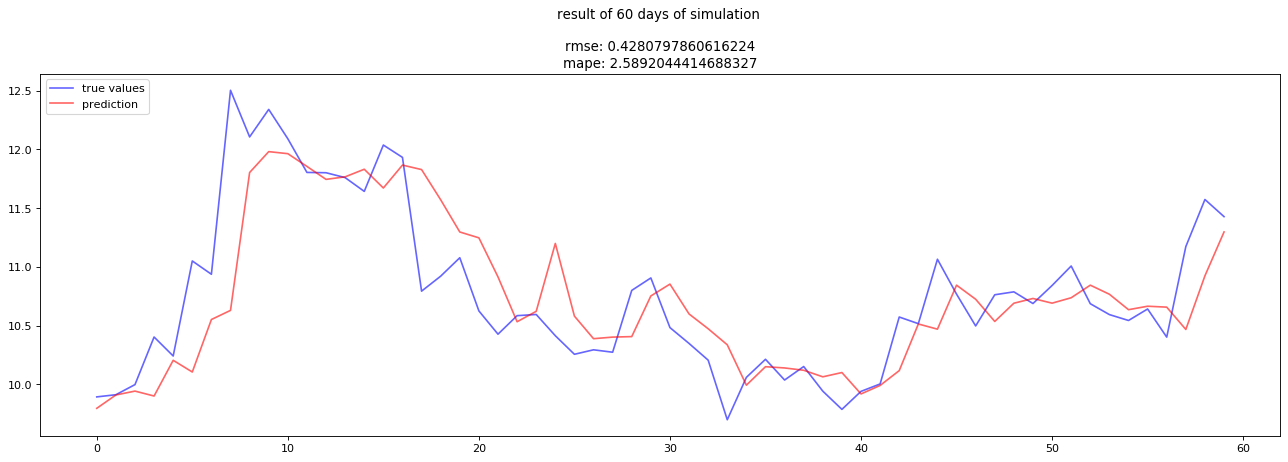


Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.58      0.62        31
           1       0.61      0.69      0.65        29

    accuracy                           0.63        60
   macro avg       0.64      0.64      0.63        60
weighted avg       0.64      0.63      0.63        60

[[18 13]
 [ 9 20]]


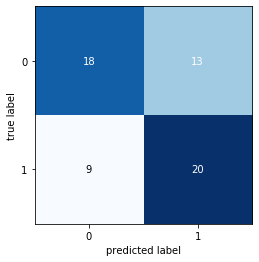

In [17]:
full_result(true_values,predict_values)

# Tune

In [48]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

all_features_list = [n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap]

comb = list(itertools.product(*all_features_list))

rmse_result = []
mape_result = []
min_i_rmse = 0
min_val_rmse = 10000
min_i_mape = 0
min_val_mape = 10000

counter = 0
comb_size = len(comb)
for i in comb: 
    counter+=1
    if counter % 5 ==0:
        print('{}%'.format(counter/comb_size*100), min_i_rmse, min_i_mape)
   
    predict_values = simulation(params = i)
    
    rmse = get_rmse(true_values,predict_values)
    mape = get_mape(true_values,predict_values)
    if min_val_mape > mape:
        min_val_mape = mape
        min_i_mape = i
    if min_val_rmse > rmse:
        min_val_rmse = rmse
        min_i_rmse = i
        
    rmse_result.append(rmse)
    mape_result.append(mape)
print('best result with rmse is :\t{}\nbest result with mape is :\t{}'.format(min_i_rmse, min_i_mape))
plot_trend(rmse_result, split_point =comb.index(min_i_rmse) ,title = 'rmse result : {}'.format(min_val_rmse) ,full_x=True)
plot_trend(mape_result, split_point =comb.index(min_i_mape) ,title = 'mape result : {}'.format(min_val_mape) ,full_x=True)

0.4629629629629629% (200, 'auto', 10, 2, 2, True) (200, 'auto', 10, 2, 2, True)
0.9259259259259258% (200, 'auto', 10, 2, 4, True) (200, 'auto', 10, 2, 4, True)
1.3888888888888888% (200, 'auto', 10, 2, 4, True) (200, 'auto', 10, 2, 4, True)
1.8518518518518516% (200, 'auto', 10, 10, 4, True) (200, 'auto', 10, 10, 4, True)
2.314814814814815% (200, 'auto', 10, 10, 4, True) (200, 'auto', 10, 10, 4, True)
2.7777777777777777% (200, 'auto', 10, 10, 4, True) (200, 'auto', 10, 10, 4, True)
3.2407407407407405% (200, 'auto', 10, 10, 4, True) (200, 'auto', 10, 10, 4, True)
3.7037037037037033% (200, 'auto', 35, 10, 4, True) (200, 'auto', 35, 10, 4, True)
4.166666666666666% (200, 'auto', 35, 10, 4, True) (200, 'auto', 35, 10, 4, True)
4.62962962962963% (200, 'auto', 35, 10, 4, True) (200, 'auto', 35, 10, 4, True)
5.092592592592593% (200, 'auto', 35, 10, 4, True) (200, 'auto', 35, 10, 4, True)
5.555555555555555% (200, 'auto', 35, 10, 4, True) (200, 'auto', 35, 10, 4, True)
6.018518518518518% (200, 'au

KeyboardInterrupt: 

In [21]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

all_features_list = [n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap]

comb = list(itertools.product(*all_features_list))

rmse_result = []
mape_result = []
min_i_rmse = (200, 'sqrt', 35, 5, 1, True)
min_val_rmse = 0.29768000889447965
min_i_mape = (200, 'sqrt', 35, 5, 1, True)
min_val_mape = 2.0716176129034523
rmse_result.append(min_val_rmse)
mape_result.append(min_val_mape)

passed_percentage = 29.629629629629626

counter = int(passed_percentage * comb_size / 100) - 1
comb_size = len(comb)
print('{}%'.format(counter/comb_size*100), min_i_rmse, min_i_mape)
for i in comb[int(passed_percentage * comb_size / 100) - 1:]: 
    counter+=1
    if counter % 5 ==0:
        print('{}%'.format(counter/comb_size*100), min_i_rmse, min_i_mape)
   
    predict_values = simulation(params = i)
    
    rmse = get_rmse(true_values,predict_values)
    mape = get_mape(true_values,predict_values)
    if min_val_mape > mape:
        min_val_mape = mape
        min_i_mape = i
    if min_val_rmse > rmse:
        min_val_rmse = rmse
        min_i_rmse = i
        
    rmse_result.append(rmse)
    mape_result.append(mape)
print('best result with rmse is :\t{}\nbest result with mape is :\t{}'.format(min_i_rmse, min_i_mape))
plot_trend(rmse_result, split_point =comb.index(min_i_rmse) ,title = 'rmse result : {}'.format(min_val_rmse) ,full_x=True)
plot_trend(mape_result, split_point =comb.index(min_i_mape) ,title = 'mape result : {}'.format(min_val_mape) ,full_x=True)

29.444444444444446% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
29.629629629629626% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
30.09259259259259% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
30.555555555555557% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
31.01851851851852% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
31.48148148148148% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
31.944444444444443% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
32.407407407407405% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
32.870370370370374% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
33.33333333333333% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
33.7962962962963% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
34.25925925925926% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)
34.72222222222222% (200, 'sqrt', 35, 5, 1, True

KeyboardInterrupt: 

In [ ]:
print('tune base on rmse')
predict_values = simulation(params = min_i_rmse)
full_result(true_values,predict_values)

print('tune base on mape')
predict_values = simulation(params = min_i_mape)
full_result(true_values,predict_values)

In [ ]:
29.629629629629626% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)

In [49]:

min_val_mape

2.0716176129034523

In [50]:

min_i_mape

(200, 'sqrt', 35, 5, 1, True)

0.29768000889447965

In [52]:
min_i_rmse 

(200, 'sqrt', 35, 5, 1, True)

In [ ]:
54.166666666666664% (200, 'sqrt', 35, 5, 1, True) (200, 'sqrt', 35, 5, 1, True)

In [24]:
54.166666666666664*comb_size/100

585.0

In [26]:
comb[586]

(1100, 'sqrt', 60, 5, 4, True)

In [22]:
rmse_result

[0.29768000889447965,
 0.343896632904586,
 0.551234582169704,
 0.3393869820221352,
 0.5797748379054187,
 0.3181516488252694,
 0.5634875186718165,
 0.3174815989519885,
 0.31983711677740173,
 0.3174791841620153,
 0.31789187039982525,
 0.3207702160308801,
 0.3185711735705584,
 0.31601970999111906,
 0.3157526175589704,
 0.31471831731607874,
 0.3185869121521506,
 0.3207702160308801,
 0.3185711735705584,
 0.31616491768583593,
 0.3185368139047011,
 0.3118447839810762,
 0.31887376678372964,
 0.3126053674515225,
 0.3191668746216281,
 0.3111497012699752,
 0.30852530811197065,
 0.31220757873270594,
 0.303963214612847,
 0.31363142511238207,
 0.31161284745009865,
 0.3053684494252873,
 0.313029217549174,
 0.3030792872149659,
 0.30889036507229684,
 0.31363142511238207,
 0.31161284745009865,
 0.30772405458939867,
 0.3031967822398686,
 0.3069219765095131,
 0.30983136973032555,
 0.3114505431368781,
 0.3128475823503889,
 0.3111497012699752,
 0.30852530811197065,
 0.31220757873270594,
 0.303963214612847,
